In [1]:
from pyannote.core import Annotation
from pyannote.pipeline import Optimizer
from pyannote.metrics.detection import DetectionErrorRate
from pyannote.database import registry, get_protocol, FileFinder
from pyannote.audio.tasks import VoiceActivityDetection
from pyannote.audio.models.segmentation import PyanNet
from pyannote.audio import Inference
from pyannote.audio.pipelines import VoiceActivityDetection as VoiceActivityDetectionPipeline
from utils import Get_RTTM
import pytorch_lightning as pl
import os

/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
torchvision is not available - cannot save figures


In [2]:
# Load database and set environment variable
registry.load_database(
    os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'yaml','My_Databases.yml')
)
os.environ["PYANNOTE_DATABASE_CONFIG"] = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets','yaml', 'My_Databases.yml')

'My_datasets.SpeakerDiarization.Detection' found in /mnt/e/Files/Acoustic_Data/Datasets/yaml/My_Databases.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


In [3]:
# Get protocol and initial training file
preprocessors = {"audio": FileFinder()}
cow_audio = get_protocol('My_datasets.SpeakerDiarization.Detection', preprocessors=preprocessors)
first_training_file = next(cow_audio.train())

In [4]:
# Train the VAD model
vad = VoiceActivityDetection(cow_audio, duration=1.5, batch_size=16)
model = PyanNet(sincnet={'stride': 10}, task=vad)
model.to("cuda")
output_directory = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets')
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=10, default_root_dir=output_directory)
trainer.fit(model)

Protocol My_datasets.SpeakerDiarization.Detection does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | In sizes      | Out sizes                                 
--------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 24000] | [1, 60, 86]                               
1 | lstm              | LSTM             | 589 K  | [1, 86, 60]   | [[1, 86, 256], [[4, 1, 128], [4, 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


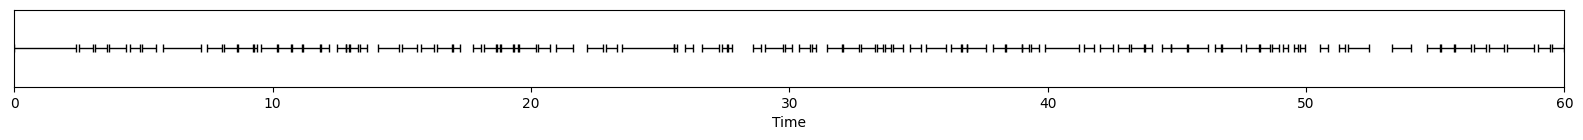

In [5]:
# Use the trained model for inference
test_files = list(cow_audio.test())
test_file = test_files[0] 
inference = Inference(model)
vad_probability = inference(test_file)
#vad_probability
expected_output = test_file["annotation"].get_timeline().support()
expected_output

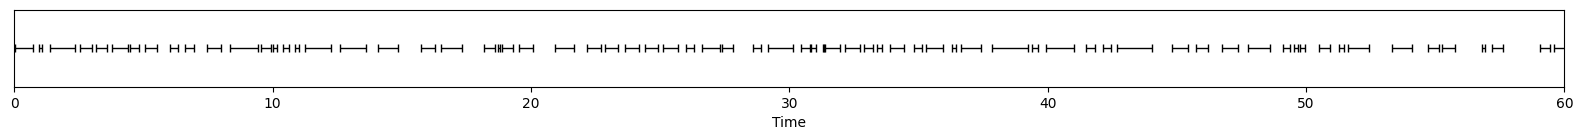

In [10]:
# Convert output to timeline and then to RTTM format
pipeline = VoiceActivityDetectionPipeline(segmentation=model)
initial_params = {"onset": 0.6, "offset": 0.5, "min_duration_on": 0.0, "min_duration_off": 0.0}
pipeline.instantiate(initial_params)
timeline = pipeline(test_file).get_timeline()
pipeline(test_file).get_timeline()

In [11]:
metric = DetectionErrorRate()

for file in cow_audio.test():
    
    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],     # this is the reference annotation
        speech,                 # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated
    
# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 27.8%


In [12]:
# Save the RTTM before parameter optimization
Get_RTTM.save_rttm(test_file, pipeline, os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'output_rttms','before_optimization.rttm'))

{'onset': 0.14159536967923808, 'offset': 0.5545112977098863, 'min_duration_on': 0.05743045415333149, 'min_duration_off': 0.02751572438219059}


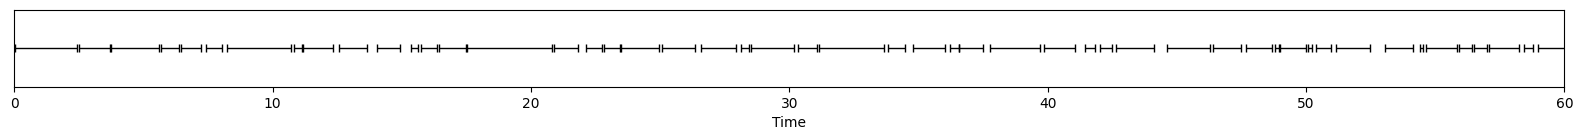

In [13]:
# Optimize parameters
optimizer = Optimizer(pipeline)
optimizer.tune(list(cow_audio.development()), 
               warm_start=initial_params, 
               n_iterations=20, 
               show_progress=False)
optimized_params = optimizer.best_params
print(optimized_params)

pipeline.instantiate(optimized_params)
optimized_pipeline = pipeline.instantiate(optimized_params)
pipeline(test_file).get_timeline()

In [14]:
metric = DetectionErrorRate()

for file in cow_audio.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])
    
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 32.5%


In [15]:
# Save the RTTM after parameter optimization
Get_RTTM.save_rttm(test_file, pipeline, os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'output_rttms','after_optimization.rttm'))

In [16]:
from utils import TXT_RTTM_Transform
input_file_before = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'output_rttms','before_optimization.rttm')
output_file_before = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'output_rttms','before_optimization.txt')
input_file_after = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'output_rttms','after_optimization.rttm')
output_file_after = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets', 'output_rttms','after_optimization.txt')
TXT_RTTM_Transform.rttm_to_txt(input_file_before, output_file_before)
TXT_RTTM_Transform.rttm_to_txt(input_file_after, output_file_after)